In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import pickle
import joblib
import time
np.random.seed(2)


In [2]:
def load_all(fname):
    return pickle.load(open(fname,"rb"))
def load_y(fname):
    return np.array(pickle.load(open(fname,"rb")))

In [3]:
#path = "D:/"
path = "/scratch/pbanerj6/sml-dataset/"
trainSamples = 75000
n_iter = 1000 
#n_trainSamples = [100,250,500,750,1000,1250,1500]
n_trainSamples = [100,500,1000,10000,20000,50000,75000]

In [4]:
X_train_all = load_all(path+"X_train_all_90.pkl")[:trainSamples]
X_val_all = load_all(path+"X_val_all_90.pkl")

y_train = load_y(path+"y_train.p")[:trainSamples]
y_val = load_y(path+"y_val.p")

In [5]:
from sklearn.linear_model import Perceptron
from sklearn.calibration import CalibratedClassifierCV

In [6]:
from sklearn.model_selection import GridSearchCV
parameters = {
     'alpha': [0.001, 0.01, 0.1, 1,0.0001],
    'tol': [0.001,0.0001],
    'validation_fraction' : [0.05,0.1,0.2],
 }

In [12]:
lr_clf = GridSearchCV(Perceptron(max_iter= n_iter, n_jobs=-1), 
                      parameters,n_jobs=1, verbose=4, iid=True,cv=5)

In [13]:
gridtime = time.time()
model = lr_clf.fit(X_train_all, y_train)
print("The Total Training Time Taken : ",time.time() - gridtime)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV] validation_fraction=0.05, tol=0.001, alpha=0.001 ................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  validation_fraction=0.05, tol=0.001, alpha=0.001, score=0.6266, total=  13.1s
[CV] validation_fraction=0.05, tol=0.001, alpha=0.001 ................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   13.5s remaining:    0.0s


[CV]  validation_fraction=0.05, tol=0.001, alpha=0.001, score=0.6155333333333334, total=  13.0s
[CV] validation_fraction=0.05, tol=0.001, alpha=0.001 ................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   27.0s remaining:    0.0s


[CV]  validation_fraction=0.05, tol=0.001, alpha=0.001, score=0.6362, total=  14.1s
[CV] validation_fraction=0.05, tol=0.001, alpha=0.001 ................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   41.5s remaining:    0.0s


[CV]  validation_fraction=0.05, tol=0.001, alpha=0.001, score=0.6296, total=   9.4s
[CV] validation_fraction=0.05, tol=0.001, alpha=0.001 ................
[CV]  validation_fraction=0.05, tol=0.001, alpha=0.001, score=0.615, total=  12.5s
[CV] validation_fraction=0.1, tol=0.001, alpha=0.001 .................
[CV]  validation_fraction=0.1, tol=0.001, alpha=0.001, score=0.6266, total=  13.1s
[CV] validation_fraction=0.1, tol=0.001, alpha=0.001 .................
[CV]  validation_fraction=0.1, tol=0.001, alpha=0.001, score=0.6155333333333334, total=  13.0s
[CV] validation_fraction=0.1, tol=0.001, alpha=0.001 .................
[CV]  validation_fraction=0.1, tol=0.001, alpha=0.001, score=0.6362, total=  14.2s
[CV] validation_fraction=0.1, tol=0.001, alpha=0.001 .................
[CV]  validation_fraction=0.1, tol=0.001, alpha=0.001, score=0.6296, total=   9.5s
[CV] validation_fraction=0.1, tol=0.001, alpha=0.001 .................
[CV]  validation_fraction=0.1, tol=0.001, alpha=0.001, score=0.

[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed: 32.5min finished


The Total Training Time Taken :  1961.8122050762177


In [14]:
model.best_score_

0.6245866666666666

In [15]:
print(model.best_params_)
for param_name in sorted(parameters.keys()):
    print("%s: %r" % (param_name, model.best_params_[param_name]))

{'validation_fraction': 0.05, 'tol': 0.001, 'alpha': 0.001}
alpha: 0.001
tol: 0.001
validation_fraction: 0.05


In [16]:
pickle.dump(model,open("Perceptron_all_"+str(trainSamples)+"_"+str(n_iter)+".pkl",'wb'))

In [17]:
X_test_all = load_all(path+"X_test_all_90.pkl")
y_test = load_y(path+"y_test.p")

In [18]:
from scipy.stats import rankdata

def mrrs(out, labels):
#     print(out,labels)
    outputs = np.argmax(out,axis=1)
    mrr = 0.0 
    for label,ranks in zip(labels,out):
        ranks = rankdata(ranks*-1)
        rank = ranks[label]
#         print(rank,ranks)
        mrr+=1/rank
    return mrr/len(labels)

def precision_at(out,labels,prank=1):
    count = 0
    for label,ranks in zip(labels,out):
        ranks = rankdata(ranks*-1)
        rank = ranks[label]
#         print(rank,ranks)
        if rank <= prank:
            count+=1
    return count/len(labels)

def mrrwrapper(qid2c,qid2indexmap,preds_prob):
    labels = []
    out = []
    for qid in qid2c.keys():
        scores = []
        for ix in qid2indexmap[qid]:
            if len(scores) < 6:
                scores.append(preds_prob[ix][1])
        if len(scores) < 6:
            continue
        out.append(scores)
        labels.append(int(qid2c[qid]))
    return mrrs(np.array(out),labels),precision_at(np.array(out),labels,1),precision_at(np.array(out),labels,3)

def load_ranking(fname):
    return pickle.load(open(path+"ranking_"+fname+".p","rb"))

In [19]:
from sklearn.metrics import accuracy_score

In [20]:
valAccuracy = []
testAccuracy = []
mrrScore = []
precisionAt1 = []
precisionAt3 = []

# For each of training sample sizes
for eachTrain in n_trainSamples:
    
    # Model with best values from grid search
    bestModel = CalibratedClassifierCV(Perceptron(max_iter= n_iter, n_jobs=-1,alpha=model.best_params_['alpha'],tol=model.best_params_['tol'],
                          validation_fraction=model.best_params_['validation_fraction']))

    print("SampleSize:",eachTrain)
    
    stime=time.time()
    bestModel.fit(X_train_all[:eachTrain],y_train[:eachTrain])   
    print("Train Time:%.2f sec"%(time.time()-stime))
    
    stime=time.time()
    preds_val = bestModel.predict(X_val_all)
    accuracy = round(accuracy_score(y_val, preds_val),4)
    valAccuracy.append(accuracy)
    print("Validation Accuracy: %.2f%%" % (accuracy * 100.0))
    print("Validation Time:%.2f sec"%(time.time()-stime))

    stime=time.time()
    preds_test = bestModel.predict(X_test_all)
    accuracy = round(accuracy_score(y_test, preds_test),4)
    testAccuracy.append(accuracy)
    print("Test Accuracy: %.2f%%" % (accuracy * 100.0))
    print("Test Time:%.2f sec"%(time.time()-stime))
    
    stime=time.time()
    preds_test_probs = bestModel.predict_proba(X_test_all)
    qid2c,qid2indexmap = load_ranking("test")
    print (mrrwrapper(qid2c,qid2indexmap,preds_test_probs))
    mrr, pAt1, pAt3 = mrrwrapper(qid2c,qid2indexmap,preds_test_probs)
    mrrScore.append(mrr)
    print("MRR:",mrr)
    print("MRR Time:%.2f sec"%(time.time()-stime))
    
    precisionAt1.append(pAt1)
    precisionAt3.append(pAt3)
    
    #input()
print (valAccuracy)
print (testAccuracy)
print (mrrScore)
print (precisionAt1)
print (precisionAt3)

SampleSize: 100
Train Time:0.13 sec


/home/psukhapa/.conda/envs/sukha/lib/python3.5/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/home/psukhapa/.conda/envs/sukha/lib/python3.5/site-packages/sklearn/calibration.py:445: RuntimeWarning: overflow encountered in exp
  E = np.exp(AB[0] * F + AB[1])
/home/psukhapa/.conda/envs/sukha/lib/python3.5/site-packages/sklearn/calibration.py:455: RuntimeWarning: overflow encountered in exp
  E = np.exp(AB[0] * F + AB[1])
/home/psukhapa/.conda/envs/sukha/lib/python3.5/site-packages/sklearn/calibration.py:457: RuntimeWarning: invalid value encountered in multiply
  TEP_minus_T1P = P * (T * E - T1)
/home/psukhapa/.conda/envs/sukha/lib/python3.5/site-packages/sklearn/calibration.py:445: RuntimeWarning: overflow encountered in exp
  E = np.exp(AB[0] * F + AB[1])
/home/psukhapa/.conda/envs/sukha

Validation Accuracy: 52.81%
Validation Time:0.47 sec
Test Accuracy: 52.47%
Test Time:0.49 sec
(0.4362814814814816, 0.19866666666666666, 0.5426666666666666)
MRR: 0.4362814814814816
MRR Time:1.06 sec
SampleSize: 500


/home/psukhapa/.conda/envs/sukha/lib/python3.5/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/home/psukhapa/.conda/envs/sukha/lib/python3.5/site-packages/sklearn/calibration.py:445: RuntimeWarning: overflow encountered in exp
  E = np.exp(AB[0] * F + AB[1])
/home/psukhapa/.conda/envs/sukha/lib/python3.5/site-packages/sklearn/calibration.py:455: RuntimeWarning: overflow encountered in exp
  E = np.exp(AB[0] * F + AB[1])
/home/psukhapa/.conda/envs/sukha/lib/python3.5/site-packages/sklearn/calibration.py:457: RuntimeWarning: invalid value encountered in multiply
  TEP_minus_T1P = P * (T * E - T1)
/home/psukhapa/.conda/envs/sukha/lib/python3.5/site-packages/sklearn/calibration.py:445: RuntimeWarning: overflow encountered in exp
  E = np.exp(AB[0] * F + AB[1])
/home/psukhapa/.conda/envs/sukha

Train Time:0.33 sec
Validation Accuracy: 52.33%
Validation Time:0.51 sec
Test Accuracy: 51.42%
Test Time:0.48 sec
(0.44201269841269875, 0.19933333333333333, 0.5613333333333334)
MRR: 0.44201269841269875
MRR Time:1.17 sec
SampleSize: 1000


/home/psukhapa/.conda/envs/sukha/lib/python3.5/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/home/psukhapa/.conda/envs/sukha/lib/python3.5/site-packages/sklearn/calibration.py:445: RuntimeWarning: overflow encountered in exp
  E = np.exp(AB[0] * F + AB[1])
/home/psukhapa/.conda/envs/sukha/lib/python3.5/site-packages/sklearn/calibration.py:455: RuntimeWarning: overflow encountered in exp
  E = np.exp(AB[0] * F + AB[1])
/home/psukhapa/.conda/envs/sukha/lib/python3.5/site-packages/sklearn/calibration.py:457: RuntimeWarning: invalid value encountered in multiply
  TEP_minus_T1P = P * (T * E - T1)
/home/psukhapa/.conda/envs/sukha/lib/python3.5/site-packages/sklearn/calibration.py:445: RuntimeWarning: overflow encountered in exp
  E = np.exp(AB[0] * F + AB[1])
/home/psukhapa/.conda/envs/sukha

Train Time:0.46 sec
Validation Accuracy: 50.00%
Validation Time:0.56 sec
Test Accuracy: 50.00%
Test Time:0.54 sec
(0.2857142857142808, 0.0, 0.0)
MRR: 0.2857142857142808
MRR Time:1.14 sec
SampleSize: 10000


/home/psukhapa/.conda/envs/sukha/lib/python3.5/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/home/psukhapa/.conda/envs/sukha/lib/python3.5/site-packages/sklearn/calibration.py:445: RuntimeWarning: overflow encountered in exp
  E = np.exp(AB[0] * F + AB[1])
/home/psukhapa/.conda/envs/sukha/lib/python3.5/site-packages/sklearn/calibration.py:455: RuntimeWarning: overflow encountered in exp
  E = np.exp(AB[0] * F + AB[1])
/home/psukhapa/.conda/envs/sukha/lib/python3.5/site-packages/sklearn/calibration.py:457: RuntimeWarning: invalid value encountered in multiply
  TEP_minus_T1P = P * (T * E - T1)
/home/psukhapa/.conda/envs/sukha/lib/python3.5/site-packages/sklearn/calibration.py:445: RuntimeWarning: overflow encountered in exp
  E = np.exp(AB[0] * F + AB[1])
/home/psukhapa/.conda/envs/sukha

Train Time:4.77 sec
Validation Accuracy: 57.89%
Validation Time:0.53 sec
Test Accuracy: 57.19%
Test Time:0.54 sec
(0.528325925925928, 0.3006666666666667, 0.672)
MRR: 0.528325925925928
MRR Time:1.15 sec
SampleSize: 20000


/home/psukhapa/.conda/envs/sukha/lib/python3.5/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/home/psukhapa/.conda/envs/sukha/lib/python3.5/site-packages/sklearn/calibration.py:445: RuntimeWarning: overflow encountered in exp
  E = np.exp(AB[0] * F + AB[1])
/home/psukhapa/.conda/envs/sukha/lib/python3.5/site-packages/sklearn/calibration.py:455: RuntimeWarning: overflow encountered in exp
  E = np.exp(AB[0] * F + AB[1])
/home/psukhapa/.conda/envs/sukha/lib/python3.5/site-packages/sklearn/calibration.py:457: RuntimeWarning: invalid value encountered in multiply
  TEP_minus_T1P = P * (T * E - T1)
/home/psukhapa/.conda/envs/sukha/lib/python3.5/site-packages/sklearn/calibration.py:445: RuntimeWarning: overflow encountered in exp
  E = np.exp(AB[0] * F + AB[1])
/home/psukhapa/.conda/envs/sukha

Train Time:14.91 sec
Validation Accuracy: 60.02%
Validation Time:0.55 sec
Test Accuracy: 59.85%
Test Time:0.52 sec
(0.538281481481483, 0.302, 0.71)
MRR: 0.538281481481483
MRR Time:1.27 sec
SampleSize: 50000


/home/psukhapa/.conda/envs/sukha/lib/python3.5/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/home/psukhapa/.conda/envs/sukha/lib/python3.5/site-packages/sklearn/calibration.py:445: RuntimeWarning: overflow encountered in exp
  E = np.exp(AB[0] * F + AB[1])
/home/psukhapa/.conda/envs/sukha/lib/python3.5/site-packages/sklearn/calibration.py:455: RuntimeWarning: overflow encountered in exp
  E = np.exp(AB[0] * F + AB[1])
/home/psukhapa/.conda/envs/sukha/lib/python3.5/site-packages/sklearn/calibration.py:457: RuntimeWarning: invalid value encountered in multiply
  TEP_minus_T1P = P * (T * E - T1)
/home/psukhapa/.conda/envs/sukha/lib/python3.5/site-packages/sklearn/calibration.py:445: RuntimeWarning: overflow encountered in exp
  E = np.exp(AB[0] * F + AB[1])
/home/psukhapa/.conda/envs/sukha

Train Time:82.74 sec
Validation Accuracy: 61.91%
Validation Time:0.45 sec
Test Accuracy: 61.73%
Test Time:0.57 sec
(0.5523904761904784, 0.32266666666666666, 0.7226666666666667)
MRR: 0.5523904761904784
MRR Time:1.12 sec
SampleSize: 75000


/home/psukhapa/.conda/envs/sukha/lib/python3.5/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/home/psukhapa/.conda/envs/sukha/lib/python3.5/site-packages/sklearn/calibration.py:445: RuntimeWarning: overflow encountered in exp
  E = np.exp(AB[0] * F + AB[1])
/home/psukhapa/.conda/envs/sukha/lib/python3.5/site-packages/sklearn/calibration.py:455: RuntimeWarning: overflow encountered in exp
  E = np.exp(AB[0] * F + AB[1])
/home/psukhapa/.conda/envs/sukha/lib/python3.5/site-packages/sklearn/calibration.py:457: RuntimeWarning: invalid value encountered in multiply
  TEP_minus_T1P = P * (T * E - T1)
/home/psukhapa/.conda/envs/sukha/lib/python3.5/site-packages/sklearn/calibration.py:445: RuntimeWarning: overflow encountered in exp
  E = np.exp(AB[0] * F + AB[1])
/home/psukhapa/.conda/envs/sukha

Train Time:66.73 sec
Validation Accuracy: 61.00%
Validation Time:0.52 sec
Test Accuracy: 61.11%
Test Time:0.59 sec
(0.5557571428571451, 0.33, 0.712)
MRR: 0.5557571428571451
MRR Time:1.10 sec
[0.5281, 0.5233, 0.5, 0.5789, 0.6002, 0.6191, 0.61]
[0.5247, 0.5142, 0.5, 0.5719, 0.5985, 0.6173, 0.6111]
[0.4362814814814816, 0.44201269841269875, 0.2857142857142808, 0.528325925925928, 0.538281481481483, 0.5523904761904784, 0.5557571428571451]
[0.19866666666666666, 0.19933333333333333, 0.0, 0.3006666666666667, 0.302, 0.32266666666666666, 0.33]
[0.5426666666666666, 0.5613333333333334, 0.0, 0.672, 0.71, 0.7226666666666667, 0.712]


In [21]:
def accuracyVisualization():
    ''' Plots the data points with the centroids
    '''
    fig = plt.figure()
    ax = plt.axes()
    ax.plot(n_trainSamples,testAccuracy,label='TestAccuracy vs TrainData',marker='o')
    ax.plot(n_trainSamples,valAccuracy,label='ValAccuracy vs TrainData',marker='.')
    plt.title("Scores vs TrainData")
    plt.legend()
    plt.xlabel("TrainData")
    plt.ylabel("Scores")
    fig.savefig("Perceptron_Accuracy_all.png")
    plt.show()

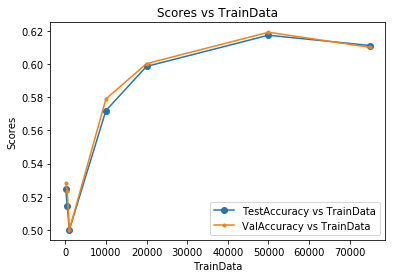

In [22]:
accuracyVisualization()

In [23]:
def mrrVisualization():
    ''' Plots the data points with the centroids
    '''
    fig = plt.figure()
    ax = plt.axes()
    ax.plot(n_trainSamples,mrrScore,label='MRR vs TrainData',marker='x')
    plt.title("Scores vs TrainData")
    plt.legend()
    plt.xlabel("TrainData")
    plt.ylabel("Scores")
    fig.savefig("Perceptron_Mrr_all.png")
    plt.show()

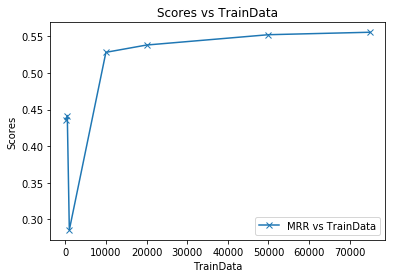

In [24]:
mrrVisualization()

In [25]:
#Precision @1 and Precision @2 Visualizations
def precisionVisualization():
    ''' Plots the data points with the centroids
    '''
    fig = plt.figure()
    ax = plt.axes()
    ax.plot(n_trainSamples,precisionAt1,label='Precision@1 vs TrainData',marker='x')
    ax.plot(n_trainSamples,precisionAt3,label='Precision@3 vs TrainData',marker='o')
    plt.title("Precision Scores vs TrainData")
    plt.legend()
    plt.xlabel("TrainData")
    plt.ylabel("Scores")
    fig.savefig("Perceptron_Precision_all.png")
    plt.show()

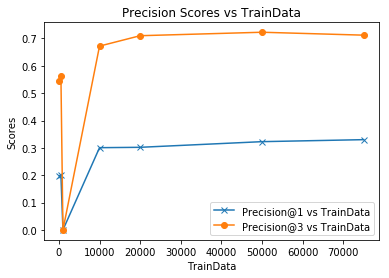

In [26]:
precisionVisualization()